In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


# Data Preparation

## Load Dataset & Initial Inspection

In [2]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Cleaning

In [ ]:
print("Missing Values:\n", df.isnull().sum())
print("\nJumlah Duplikasi:", df.duplicated().sum())

# Jika ada duplikasi → hapus
df.drop_duplicates(inplace=True)

Missing Values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Jumlah Duplikasi: 0


## Validation

In [6]:
# Deteksi nilai medis yang tidak masuk akal
print("RestingBP == 0 :", df[df['RestingBP'] == 0].shape[0])
print("Cholesterol == 0 :", df[df['Cholesterol'] == 0].shape[0])

RestingBP == 0 : 1
Cholesterol == 0 : 172


In [7]:
# Perbaiki nilai anomali -> ganti median sesuai domain klinis
df.loc[df['RestingBP'] == 0, 'RestingBP'] = df['RestingBP'].median()
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = df['Cholesterol'].median()

# Exploratory Data Analysis (EDA)

In [8]:
print("Shape:", df.shape)

Shape: (918, 12)


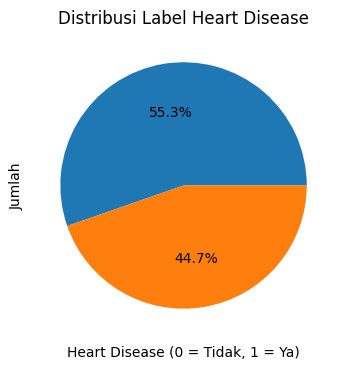

In [9]:
# Distribusi Target (Heart Disease)
plt.figure(figsize=(6,4))
plt.pie(x=df['HeartDisease'].value_counts(), autopct="%0.1f%%")
plt.title("Distribusi Label Heart Disease")
plt.xlabel("Heart Disease (0 = Tidak, 1 = Ya)")
plt.ylabel("Jumlah")
plt.show()

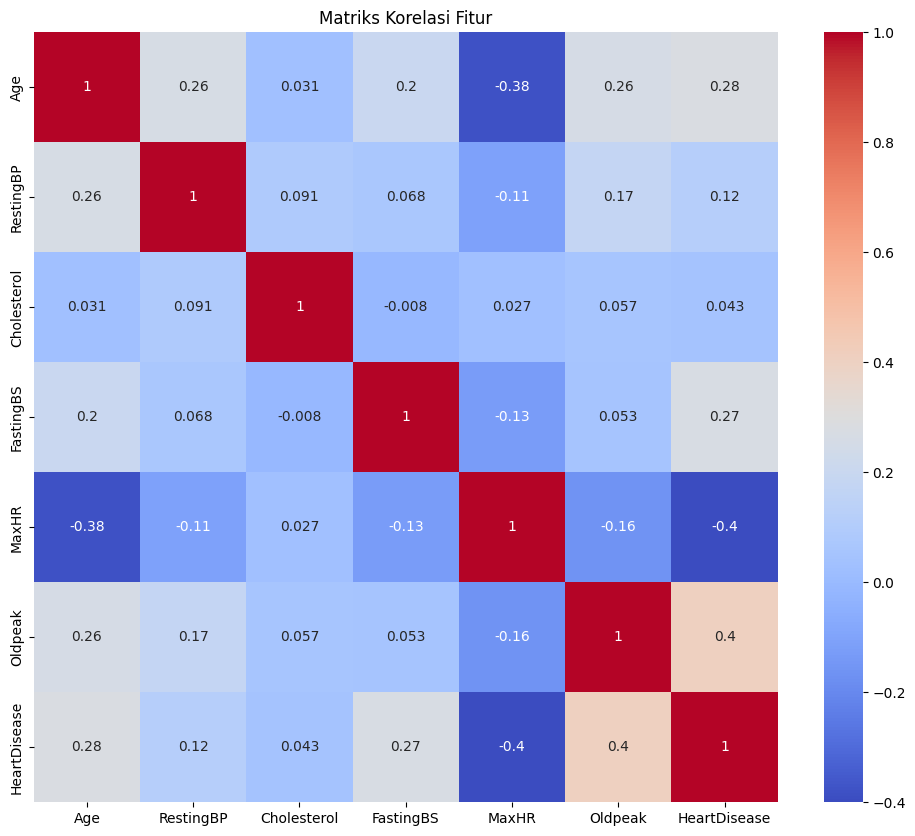

In [10]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12,10))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriks Korelasi Fitur")
plt.show()

# Data Visualization

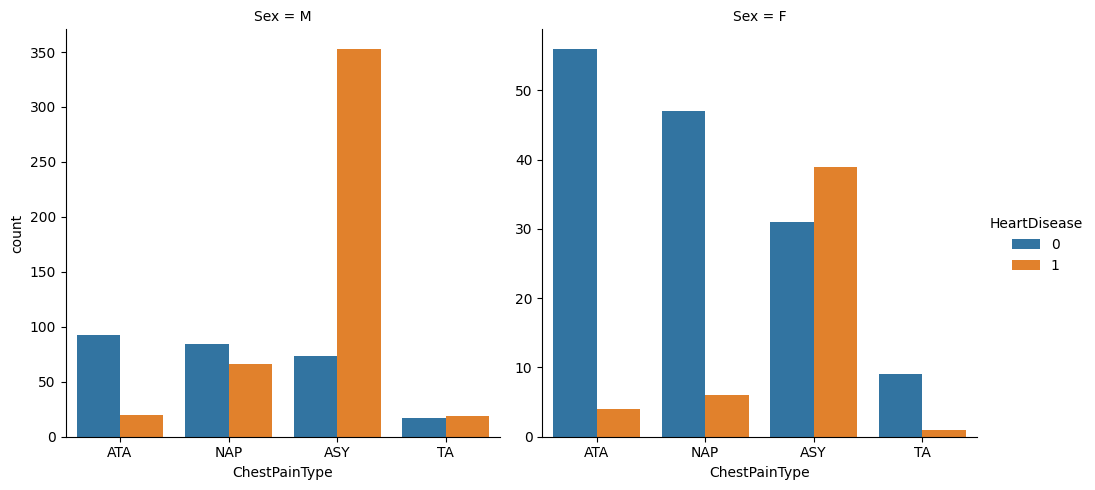

In [11]:
# Visualisasi 1 - ChestPainType vs HeartDisease
sns.catplot(df, x="ChestPainType", hue="HeartDisease", kind="count", col="Sex", sharey=False)

plt.show()

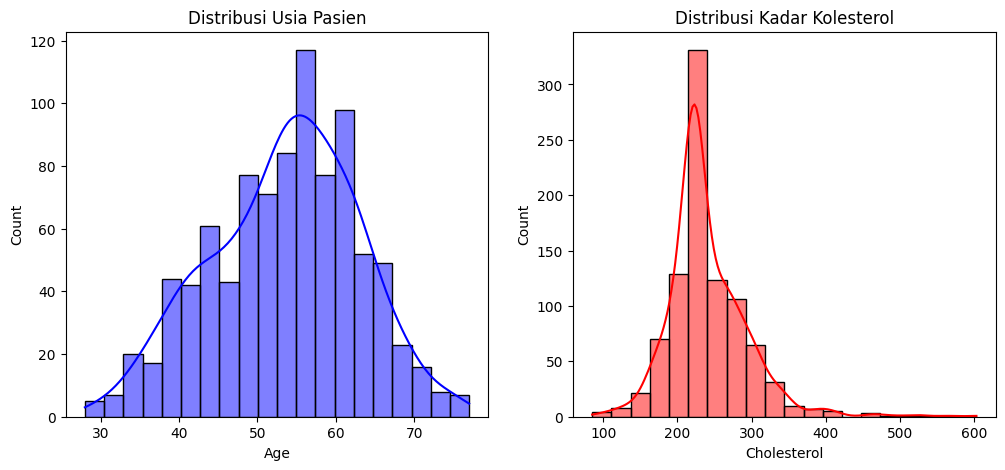

In [12]:
# Visualisasi 2 - Distribusi Age dan Cholesterol
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['Age'], kde=True, bins=20, color='blue')
plt.title("Distribusi Usia Pasien")

plt.subplot(1,2,2)
sns.histplot(df['Cholesterol'], kde=True, bins=20, color='red')
plt.title("Distribusi Kadar Kolesterol")
plt.show()

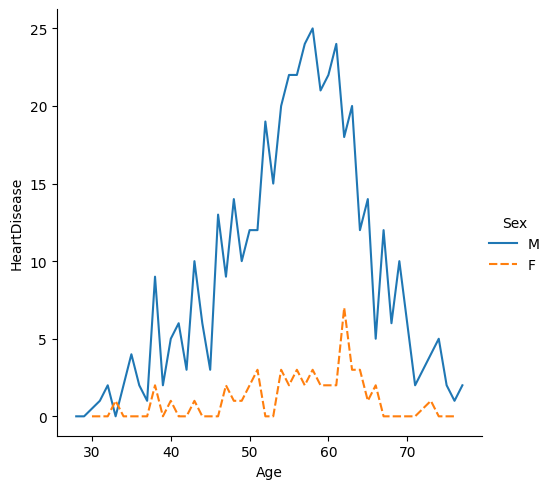

In [13]:
# Visualisasi 3 - 

grouped_df = df.groupby(['Age', 'Sex'], as_index=False)['HeartDisease'].sum()
sns.relplot(
    data=grouped_df,
    x="Age", y="HeartDisease", hue="Sex", style="Sex", kind="line"
)
plt.show()

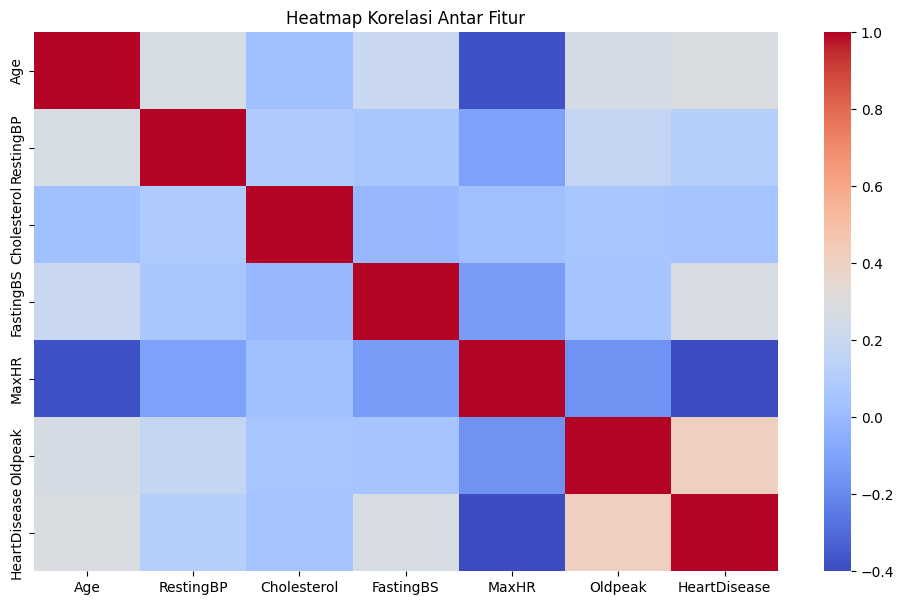

In [14]:
# Visualisasi 4 - Semua Fitur Numerik
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

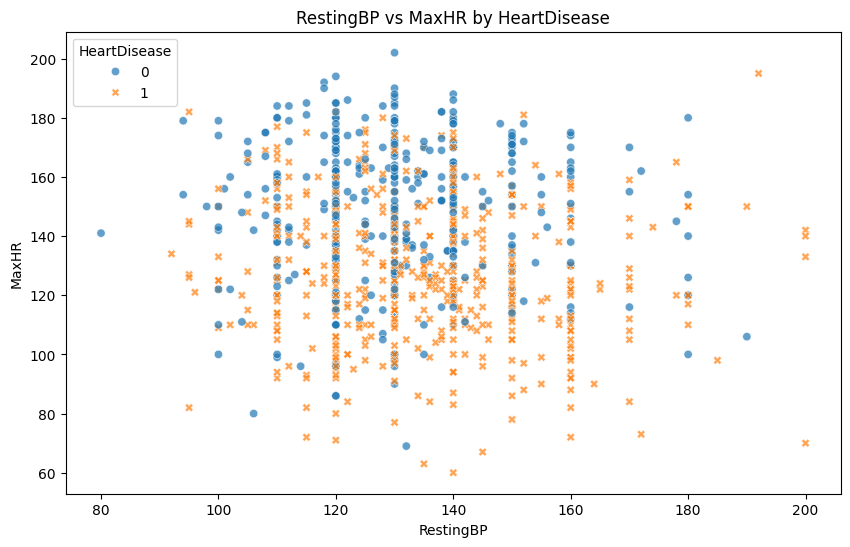

In [15]:
# Visualisasi 5 - RestingBP vs MaxHR dengan HeartDisease sebagai hue
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='RestingBP',
    y='MaxHR',
    hue='HeartDisease',
    style='HeartDisease',
    # palette='coolwarm',
    alpha=0.7
)
plt.title("RestingBP vs MaxHR by HeartDisease")
plt.show()

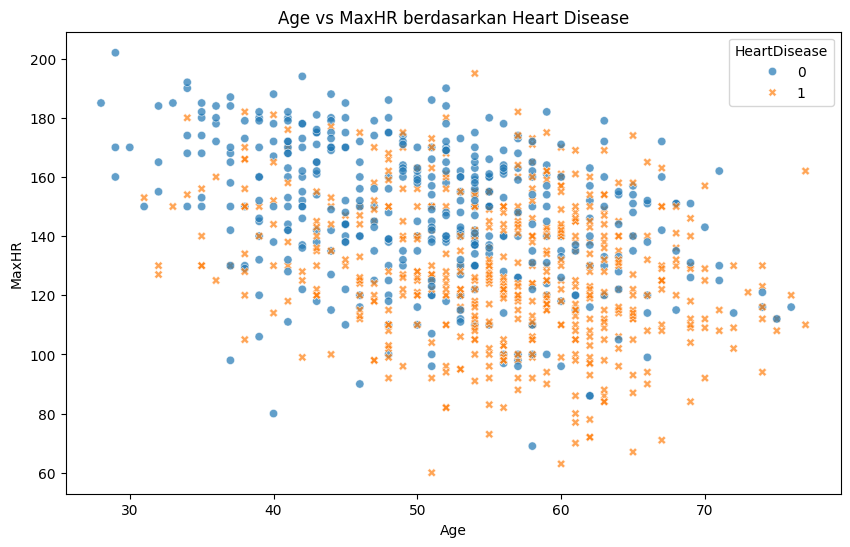

In [16]:
# Visual 6 - Hubungan Age vs MaxHR Based on Target Label
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Age', y='MaxHR', hue='HeartDisease', alpha=0.7, style='HeartDisease',)
plt.title("Age vs MaxHR berdasarkan Heart Disease")
plt.show()

## Encoding

In [17]:
categorical_binary = ['Sex', 'ExerciseAngina']
categorical_multiclass = ['ChestPainType', 'RestingECG', 'ST_Slope']

In [18]:
# Label encoding untuk binary
# One-hot encoding untuk multi-class

# Binary to 0/1
for col in categorical_binary:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_multiclass, drop_first=True)

df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,True,False,False,True,False,False,True
1,49,0,160,180,0,156,0,1.0,1,False,True,False,True,False,True,False
2,37,1,130,283,0,98,0,0.0,0,True,False,False,False,True,False,True
3,48,0,138,214,0,108,1,1.5,1,False,False,False,True,False,True,False
4,54,1,150,195,0,122,0,0.0,0,False,True,False,True,False,False,True


# Model Machine Learning

In [19]:
# Target dan fitur
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (918, 15)
y shape: (918,)


In [20]:
y.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=41,
    stratify=y   # menjaga proporsi kelas
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

Train size: 734
Test size : 184


In [22]:
y_test.value_counts()

HeartDisease
1    102
0     82
Name: count, dtype: int64

In [23]:
# Scaling Fitur Numerik
scaler = StandardScaler()

# Fit di train, transform train & test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_prepared = X_train_scaled
X_test_prepared  = X_test_scaled

## Hyperparameter Tuning (GridSearchCV)


## Logistic Regression

In [24]:
# Grid search untuk mencari hyperparameter terbaik Logistic Regression

tune_selector = SelectKBest(score_func=f_classif, k=10)

tune_pipe = Pipeline([
    ('select', tune_selector),
    ('clf', LogisticRegression(max_iter=1000, random_state=41)),
])

param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'lbfgs', 'saga'],
    'clf__penalty': ['l2'],
    'select__k': [3, 4, 6, 8, 10, 12]
}

grid = GridSearchCV(
    estimator=tune_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train_prepared, y_train)

print("Best params (LogReg):", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_log_reg_params = {k.replace('clf__',''): v for k, v in grid.best_params_.items()}


Best params (LogReg): {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'select__k': 10}
Best CV AUC: 0.9177837439084051


In [25]:
# Evaluasi Akurasi
# Prediksi
y_pred = grid.predict(X_test_prepared)

# Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (Logistic Regression): {acc:.4f}")

Accuracy (Logistic Regression): 0.8913


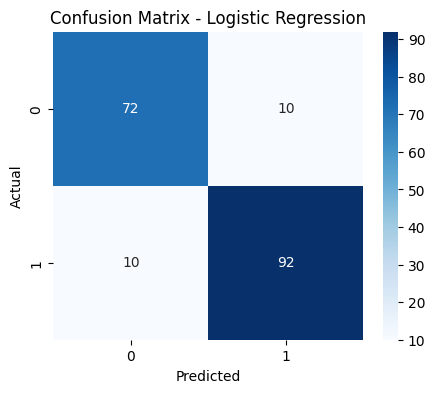


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.90      0.90      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

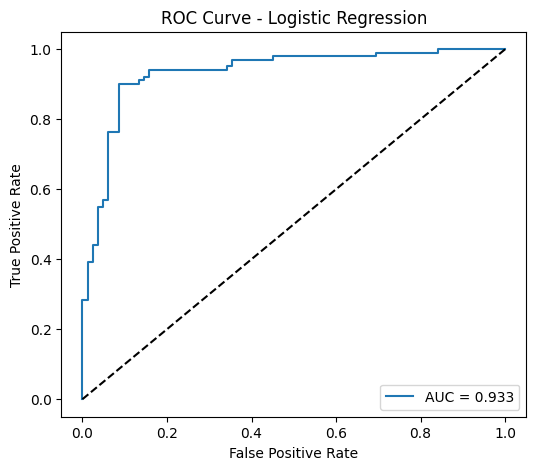

In [27]:
# Probabilitas kelas positif
y_proba = grid.predict_proba(X_test_prepared)[:, 1]

# Hitung ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # garis random
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [28]:
# Grid search untuk Random Forest (menggunakan data yang sudah dipreprocess)
rf_tune_selector = SelectKBest(score_func=f_classif, k=10)

rf_tune_pipe = Pipeline([
    ('select', rf_tune_selector),
    ('model', RandomForestClassifier(random_state=41, class_weight='balanced')),
])

rf_param_grid = {
    'select__k': [3, 5, 7, 9, 12, 15],
    'model__n_estimators': [100, 200, 400, 600, 800],
    'model__max_depth': [None, 4, 8, 12, 16],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=rf_tune_pipe,
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train_prepared, y_train)

print("Best params (RF):", rf_grid.best_params_)
print("Best CV AUC (RF):", rf_grid.best_score_)

best_rf_params = {k.replace('model__', ''): v for k, v in rf_grid.best_params_.items() if k.startswith('model__')}
best_rf_k = rf_grid.best_params_.get('select__k')
best_rf_estimator = rf_grid.best_estimator_


Best params (RF): {'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200, 'select__k': 15}
Best CV AUC (RF): 0.9222992484781104


In [29]:
# Prediksi
y_pred_rf = rf_grid.predict(X_test_prepared)

# Evaluasi
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {acc_rf:.4f}")


Accuracy (Random Forest): 0.8859


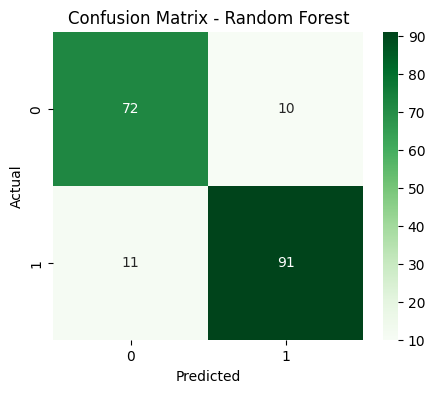


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        82
           1       0.90      0.89      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



In [30]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report - Random Forest")
print(classification_report(y_test, y_pred_rf))

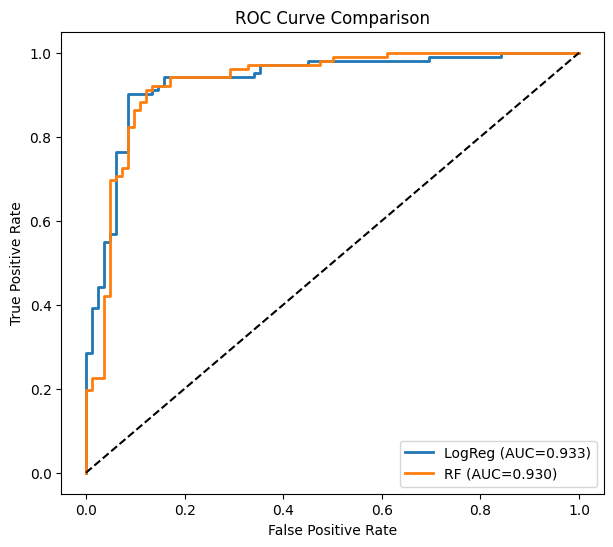

In [31]:
y_proba_rf = rf_grid.predict_proba(X_test_prepared)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7,6))

# Logistic Regression (dari kode sebelumnya)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc:.3f})", linewidth=2)

# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_rf:.3f})", linewidth=2)

plt.plot([0,1], [0,1], "k--")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## XGBoost

In [32]:
# Grid search untuk XGBoost (menggunakan data yang sudah dipreprocess)
from xgboost import XGBClassifier

xgb_tune_selector = SelectKBest(score_func=f_classif, k=10)

xgb_tune_pipe = Pipeline([
    ('select', xgb_tune_selector),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=41,
        eval_metric='logloss'
    )),
])

xgb_param_grid = {
    'select__k': [4, 6, 8, 10, 12],
    'model__n_estimators': [200, 300, 400, 600],
    'model__learning_rate': [0.03, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 5, 6],
    'model__subsample': [0.7, 0.85, 1.0],
    'model__colsample_bytree': [0.7, 0.85, 1.0],
    'model__min_child_weight': [1, 3, 5]
}

xgb_grid = GridSearchCV(
    estimator=xgb_tune_pipe,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_grid.fit(X_train_prepared, y_train)

print("Best params (XGB):", xgb_grid.best_params_)
print("Best CV AUC (XGB):", xgb_grid.best_score_)

best_xgb_params = {k.replace('model__', ''): v for k, v in xgb_grid.best_params_.items() if k.startswith('model__')}
best_xgb_k = xgb_grid.best_params_.get('select__k')
best_xgb_estimator = xgb_grid.best_estimator_


Best params (XGB): {'model__colsample_bytree': 0.85, 'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__min_child_weight': 5, 'model__n_estimators': 200, 'model__subsample': 0.7, 'select__k': 12}
Best CV AUC (XGB): 0.9226279736866173


In [33]:
y_pred_xgb = xgb_grid.predict(X_test_prepared)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy (XGBoost): {acc_xgb:.4f}")


Accuracy (XGBoost): 0.8913


In [34]:
print("\nClassification Report - XGBoost")
print(classification_report(y_test, y_pred_xgb))


Classification Report - XGBoost
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        82
           1       0.91      0.89      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [35]:
y_proba_xgb = xgb_grid.predict_proba(X_test_prepared)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"AUC (XGBoost): {roc_auc_xgb:.4f}")

AUC (XGBoost): 0.9321


## SVM

In [36]:
# Grid search untuk SVM (menggunakan data yang sudah dipreprocess)
from sklearn.svm import SVC

svm_tune_selector = SelectKBest(score_func=f_classif, k=10)

svm_tune_pipe = Pipeline([
    ('select', svm_tune_selector),
    ('clf', SVC(probability=True, random_state=41)),
])

svm_param_grid = {
    'select__k': [3, 5, 7, 9, 12],
    'clf__C': [0.01, 0.1, 1, 10, 50],
    'clf__gamma': [0.001, 0.01, 'scale', 'auto'],
    'clf__kernel': ['rbf']
}

svm_grid = GridSearchCV(
    estimator=svm_tune_pipe,
    param_grid=svm_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

svm_grid.fit(X_train_prepared, y_train)

print("Best params (SVM):", svm_grid.best_params_)
print("Best CV AUC (SVM):", svm_grid.best_score_)

best_svm_params = {k.replace('clf__', ''): v for k, v in svm_grid.best_params_.items() if k.startswith('clf__')}
best_svm_k = svm_grid.best_params_.get('select__k')
best_svm_estimator = svm_grid.best_estimator_


Best params (SVM): {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'select__k': 12}
Best CV AUC (SVM): 0.9149931108738697


In [37]:
y_pred_svm = svm_grid.predict(X_test_prepared)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {acc_svm:.4f}")

print("Classification Report - SVM")
print(classification_report(y_test, y_pred_svm))


Accuracy (SVM): 0.8913
Classification Report - SVM
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.90      0.90      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [38]:
print("\nClassification Report - SVM")
print(classification_report(y_test, y_pred_svm))


Classification Report - SVM
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.90      0.90      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [39]:
y_proba_svm = svm_grid.predict_proba(X_test_prepared)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print(f"AUC (SVM): {roc_auc_svm:.4f}")

AUC (SVM): 0.9379


## KNN

In [40]:
# Grid search untuk KNN (menggunakan data yang sudah dipreprocess)
from sklearn.neighbors import KNeighborsClassifier

knn_tune_selector = SelectKBest(score_func=f_classif, k=10)

knn_tune_pipe = Pipeline([
    ('select', knn_tune_selector),
    ('clf', KNeighborsClassifier()),
])

knn_param_grid = {
    'select__k': [3, 5, 7, 9, 12],
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

knn_grid = GridSearchCV(
    estimator=knn_tune_pipe,
    param_grid=knn_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

knn_grid.fit(X_train_prepared, y_train)

print("Best params (KNN):", knn_grid.best_params_)
print("Best CV AUC (KNN):", knn_grid.best_score_)

best_knn_params = {k.replace('clf__', ''): v for k, v in knn_grid.best_params_.items() if k.startswith('clf__')}
best_knn_k = knn_grid.best_params_.get('select__k')
best_knn_estimator = knn_grid.best_estimator_


Best params (KNN): {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance', 'select__k': 12}
Best CV AUC (KNN): 0.909980424072565


In [41]:
y_pred_knn = knn_grid.predict(X_test_prepared)

acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (KNN): {acc_knn:.4f}")

print("Classification Report - KNN")
print(classification_report(y_test, y_pred_knn))


Accuracy (KNN): 0.9022
Classification Report - KNN
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        82
           1       0.92      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [42]:
print("\nClassification Report - KNN")
print(classification_report(y_test, y_pred_knn))


Classification Report - KNN
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        82
           1       0.92      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [43]:
y_proba_knn = knn_grid.predict_proba(X_test_prepared)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
print(f"AUC (KNN): {roc_auc_knn:.4f}")

AUC (KNN): 0.9280


# Perbandingan Akurasi Model

In [44]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM", "KNN"],
    "Accuracy": [acc, acc_rf, acc_xgb, acc_svm, acc_knn],
    "AUC": [roc_auc, roc_auc_rf, roc_auc_xgb, roc_auc_svm, roc_auc_knn]
})

comparison

,Model,Accuracy,AUC
0,Logistic Regression,0.891304,0.933286
1,Random Forest,0.885870,0.929938
2,XGBoost,0.891304,0.932090
3,SVM,0.891304,0.937948
4,KNN,0.902174,0.927965


In [ ]:
# Ensemble hard voting menggunakan estimator hasil grid search
from sklearn.ensemble import VotingClassifier

voting_estimators = []

# Logistic Regression
if 'grid' in globals():
    voting_estimators.append(('logreg', grid.best_estimator_))
else:
    logreg_default = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=8)),
        ('clf', LogisticRegression(max_iter=1000, random_state=41)),
    ])
    voting_estimators.append(('logreg', logreg_default))

# Random Forest
if 'best_rf_estimator' in globals():
    voting_estimators.append(('rf', best_rf_estimator))
elif 'rf' in globals():
    voting_estimators.append(('rf', rf))
else:
    rf_fallback = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=8)),
        ('model', RandomForestClassifier(random_state=41, class_weight='balanced')),
    ])
    voting_estimators.append(('rf', rf_fallback))

# XGBoost
if 'best_xgb_estimator' in globals():
    voting_estimators.append(('xgb', best_xgb_estimator))
elif 'xgb' in globals():
    voting_estimators.append(('xgb', xgb))
else:
    xgb_fallback = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=8)),
        ('model', XGBClassifier(random_state=41, eval_metric='logloss')),
    ])
    voting_estimators.append(('xgb', xgb_fallback))

# SVM
if 'best_svm_estimator' in globals():
    voting_estimators.append(('svm', best_svm_estimator))
elif 'svm' in globals():
    voting_estimators.append(('svm', svm))
else:
    svm_fallback = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=8)),
        ('clf', SVC(probability=True, random_state=41)),
    ])
    voting_estimators.append(('svm', svm_fallback))

# KNN
if 'best_knn_estimator' in globals():
    voting_estimators.append(('knn', best_knn_estimator))
elif 'knn' in globals():
    voting_estimators.append(('knn', knn))
else:
    knn_fallback = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=8)),
        ('clf', KNeighborsClassifier(n_neighbors=7)),
    ])
    voting_estimators.append(('knn', knn_fallback))

voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_clf.fit(X_train_prepared, y_train)

y_pred_vote = voting_clf.predict(X_test_prepared)
acc_vote = accuracy_score(y_test, y_pred_vote)
print(f"Accuracy (Soft Voting Ensemble): {acc_vote:.4f}")

print("\nClassification Report - Soft Voting")
print(classification_report(y_test, y_pred_vote))


Accuracy (Hard Voting Ensemble): 0.9022

Classification Report - Hard Voting
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        82
           1       0.92      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

